In [15]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image
import random


In [2]:
data_root = Path(r"C:/Users/Jimmy/OneDrive/Desktop/test/DS6050_Ai_Detection")  # adjust as needed
val_dir = data_root / "validation"

batch_size = 32

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# dataloader loads alphabetically, so we need to swap labels
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        # Swap label: make 'real' = 0, 'fake' = 1
        label = 1 - label
        return img, label

In [8]:
val_dataset = CustomImageFolder(root=str(val_dir), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Validating on {len(val_dataset)} images.")


Validating on 28340 images.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights=None)  # no pretrained needed here
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

model.load_state_dict(torch.load("training/best_resnet50_baseline.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully.")

Using device: cuda
Model loaded successfully.


In [10]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.96      0.91      0.94     14170
    Fake (1)       0.92      0.96      0.94     14170

    accuracy                           0.94     28340
   macro avg       0.94      0.94      0.94     28340
weighted avg       0.94      0.94      0.94     28340



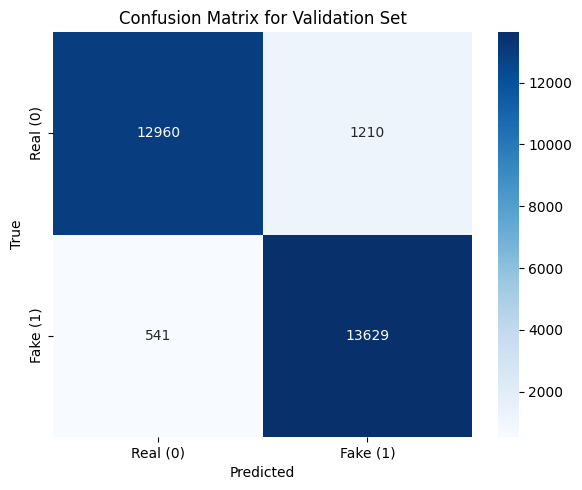

In [28]:
cm = confusion_matrix(all_labels, all_preds)
class_names = ["Real (0)", "Fake (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Validation Set")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [13]:
false_positives = []
false_negatives = []

for idx in range(len(val_dataset)):
    img, label = val_dataset[idx]
    img = img.unsqueeze(0).to(device)
    pred = torch.argmax(model(img), dim=1).item()
    true_label = label

    # Retrieve file path
    path, _ = val_dataset.samples[idx]
    orig_label_from_folder = val_dataset.samples[idx][1]
    # After flipping: real = 0, fake = 1
    true_label = 1 - orig_label_from_folder

    # FP: TRUE REAL (0) predicted FAKE (1)
    if true_label == 0 and pred == 1:
        false_positives.append(path)

    # FN: TRUE FAKE (1) predicted REAL (0)
    if true_label == 1 and pred == 0:
        false_negatives.append(path)

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

False Positives: 1209
False Negatives: 541


In [ ]:
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

def load_raw_image(path):
    return Image.open(path).convert("RGB")

def plot_fp_fn_samples(false_positives, false_negatives, num_per_row=3, save_path="error_analysis.png"):
    """
    Plot false positives in row 1 and false negatives in row 2.
    
    num_per_row controls how many images per row.
    """
    
    # Choose samples
    fp_samples = random.sample(false_positives, min(num_per_row, len(false_positives)))
    fn_samples = random.sample(false_negatives, min(num_per_row, len(false_negatives)))
    
    rows = 2
    cols = num_per_row

    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 6))
    
    if cols == 1:
        axs = np.array([[axs[0]], [axs[1]]])
    
    for idx in range(cols):
        ax = axs[0, idx]
        
        if idx < len(fp_samples):
            img_path = fp_samples[idx]
            img = load_raw_image(img_path)
            ax.imshow(img)
            ax.set_title(f"FP (Real→Fake)\n{Path(img_path).name}")
        else:
            ax.axis("off")
            continue
        
        ax.axis("off")
    
    for idx in range(cols):
        ax = axs[1, idx]
        
        if idx < len(fn_samples):
            img_path = fn_samples[idx]
            img = load_raw_image(img_path)
            ax.imshow(img)
            ax.set_title(f"FN (Fake→Real)\n{Path(img_path).name}")
        else:
            ax.axis("off")
            continue
        
        ax.axis("off")
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


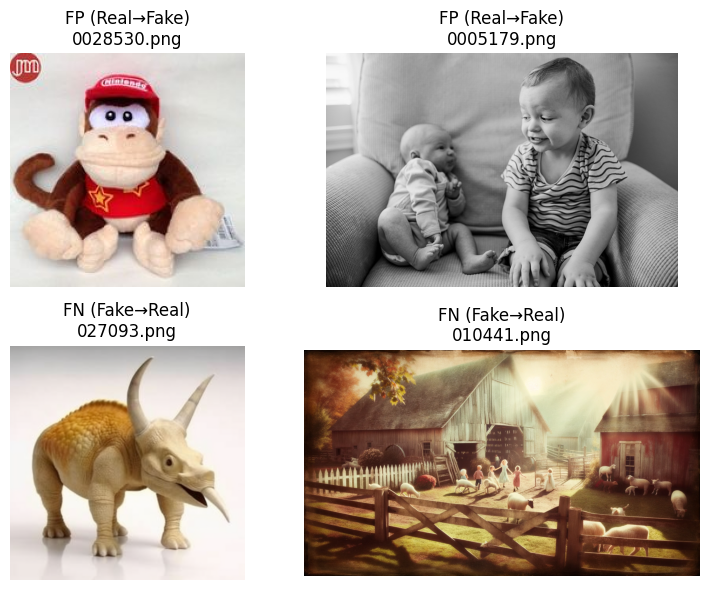

In [31]:
plot_fp_fn_samples(false_positives, false_negatives, num_per_row=2)
